In [1]:
%run Latex_macros.ipynb

<IPython.core.display.Latex object>

In [2]:
# My standard magic !  You will see this in almost all my notebooks.

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

%matplotlib inline

In [3]:
import unsupervised_helper

%aimport unsupervised_helper

vp = unsupervised_helper.VanderPlas()


**References**

- Triplet Loss: [FaceNet: A Unified Embedding for Face Recognition and Clustering](https://arxiv.org/pdf/1503.03832.pdf)
- Sentence BERT: [entence-BERT: Sentence Embeddings using Siamese BERT-Networks](https://arxiv.org/pdf/1908.10084.pdf))



# Embeddings

We speculate that a Neural Network is creating an alternate representation of the input
- into a latent space that enables a Head Layer (e.g., Classifier) to do its work
- training the model produces a representation that has features useful to the Head to complete its task
 (e.g., Classification)

We will refer to these alternate representations as *embeddings*.

When we plot embeddings in the latent space
- we might hope to see clustering of examples that are related

For example, here is a plot of a subset of the 10 digits in a 2D latent space

In [4]:
vpt = unsupervised_helper.VanderPlas()

subset1 = [ 0, 4, 7, 9 ]
rh_digits = unsupervised_helper.Reconstruct_Helper( subset=[])
rh_digits.create_data_digits(subset=subset1)

n_components = 8
_= rh_digits.fit(n_components=n_components)

# Get X tilde and the targets
Xtilde = rh_digits.dataProj
y = rh_digits.targets

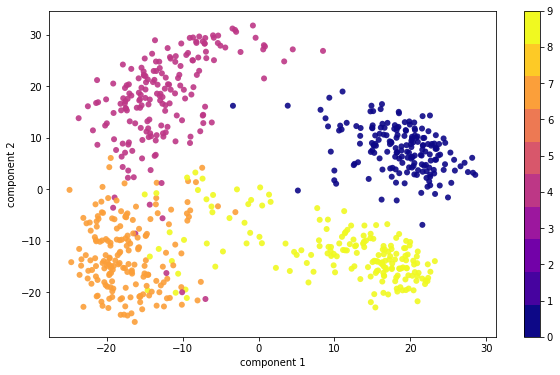

In [5]:
vpt.digits_subset_show_clustering(Xtilde, y, save_file="/tmp/digits_subset_cluster.jpg" )

And here is the clustering of text articles across different classes.

If such clusters were associated with class labels, the Classifier Head's job would be facilitated.

<table>
    <tr>
        <th><center>Text Embeddings</center></th>
    </tr>
    <tr>
        <td><img src="images/sbert_clustering.png" width-60%></td>
    </tr>
   
</table>
 <br>
    Attribution: https://joeddav.github.io/blog/2020/05/29/ZSL.html


We also hypothesize that 
- that *intermediate* layers (distance greater than 1 from the Head) produced meaningful embeddings
- in Neural Style Transfer we hypothesized
    - the representation of shallow layers captures "syntax" (e.g. Content)
    - the representation of deeper layers captures "semantics" (e.g., Style)


# What does clustering enable ?

If a NN produced embeddings such that had the *desirable property* that
- the distance between the embeddings of related examples
- was *closer*
- than the distance between the embeddings of unrelated examples

what could we do ?

## Zero-shot classification

Given an example and a set of possible labels
- using a pre-trained NN
- embed the example
- embed each of the labels

The label whose embedding was closest to that of the example would hopefully be the
correct label for the example.

This is *zero shot*
- since we are not fine-tuning
- or changing the weights
- of the pre-trained NN used to create the embeddings

A simple example: facial (or image) recognition
- compare the embedding of an image
- with the embeddings of the fixed number of images for each class (e.g., person)

## Semantic search

Want to create your own search engine ?
- create embeddings (using a NN for NLP) for each document
- create an embedding for your query

The document whose embedding is closest to the query's embedding would hopefully be the correct result.

**Note**

This is the basis for *Vector Stores*
- augmenting a LLM with your own data (e.g., GPT)

# Creating embeddings for similarity

The problem is that the hoped-for desirable property *may not be true* without specifically
requiring that in training or fine-tuning.

We can train a Neural Network to have this property by 
- creating a Loss function to express this objective


One such objective is the [Triplet Loss](https://arxiv.org/pdf/1503.03832.pdf)

Consider an input $a$ (the "anchor")
- with related input $p$ ("positive")
- with unrelated input $n$ ("negative")

Let 
- $s_a, s_p, s_n$ be the embedding produced by some layer, given input $a, p, n$
- $|| s - s' ||$ be a measure of the distance (inverse of similarity, always non-negative) between two embeddings $s, s'$

The Triplet Loss objective is to *minimize*
$$
\max{}( || s_a - s_p || - || s_a - s_n || + \epsilon, 0)
$$

The loss is minimized when
- $s_a$ is close to $s_p$
- $s_a$ is far from $s_n$

That is the embedding for anchor
- $a$ is very similar to that for $p$
- $a$ is very dissimilar to that for $n$

$\epsilon$ is called the *margin*
- how much farther the negative $n$ must be from anchor $a$ than positive $p$

$$
\begin{array} \\
\text{If } & \max{}( || s_a - s_p || - || s_a - s_n || + \epsilon, 0) < 0 \\
\text{then} & || s_a - s_p || - || s_a - s_n || + \epsilon < 0 \\
\text{re-arranging} & || s_a - s_p || < || s_a - s_n || - \epsilon \\
\end{array}
$$
so $|| s_a - s_n ||$ must be at least $\epsilon$ greater than $|| s_a - s_p ||$.

This reduces the need for the optimizer to make $a$ and $p$ *exactly* coincide (so that $|| s_a - s_p || = 0$)

By training (or fine-tuning a pre-trained model) with the Triplet Loss
- we enforce the "hoped-for" property by design

# Example: Sentence Embeddings

To illustrate, we show [Sentence BERT](https://arxiv.org/pdf/1908.10084.pdf)
- fine-tunes the embeddings produced by BERT
- in order to make related sentences close in embedding space



Sentence-BERT builds a network based on the embeddings produced by BERT.

BERT is an Encoder style transformer.

A Transformer Encoder creates a Context Sensitive embedding of each input position.

By reducing the sequence (over positions) embeddings to a single embedding
- we can obtain a fixed length encoding of a variable length sequence of tokens

**Aside**

Historically, there are some common ways to perform the reduction of a sequence to a single value
- pooling (average over the embeddings)
- using a beginning/end "special" token (e.g., $\langle \text{CLS} \rangle$ to capture the summary of the entire sequence



Here is the architecture

<table>
    <tr>
        <th><center>Sentence BERT</th>
    </tr>
    <tr>
        <td><img src=images/sentence_bert_diag.png></td>
    </tr>
   
</table>
 <br>
    Attribution: https://arxiv.org/pdf/1908.10084.pdf#page=3

The pre-trained BERT model is *shared* across two inputs: Sentence A and Sentence B
- "weights are tied"
- BERT's weights are fine-tuned via the Triplet Loss objective

The sequence output of BERT is reduce by pooling (in this case)
- Sentence A is embedded as $u$
- Sentence B is embedded as $v$

In the diagram on the right, the Triplet Objective
- is recast as maximizing similarity (cosine distance)
- rather than minimizing distance 


**Aside**

The diagram on the left is for producing embeddings for a specific task
- entailment
    - Does Sentence B logically follow from Sentence A
- and hence is expressed as a Classification objective over labels $\{ \text{"Entail", "Does not entail"} \}$

The inputs to the classifier are the concatenation of
- the embedding $u$ of Sentence A
- the embedding $v$ of Sentence B
- the difference in the embeddings

(Presumably these three inputs facilitate Classsification)

The model is trained via batches that contain a mixture of
- Positive examples: Sentence A and Sentence B *are related* (anchor $a$ and positive $p$)
- Negative examples: Sentence A and Sentence B *are un-related* (anchor $a$ and positive $n$)

Triplet loss is minimized (or Utility maximized) in each batch.

## Performance

[Here](https://github.com/UKPLab/sentence-transformers/blob/master/docs/pretrained-models/sts-models.md#performance-comparison) is a comparison of Sentence BERT to other methods

The Sentence Embedding (Universal Sentence Encoder) scores highest
- outperforms Word Embeddings (the two GloVe entries)
- it *greatly outperforms* the simple reduction methods used on plain BERT output
    - pooling (BERT as a service avg embeddings)
    - special `<CLS>` token (BERT as a service CLS vector)

**Note**

The "sophisticated" BERT, when using simple reduction methods
- underperforms the "old school" word embeddings !


In [6]:
print("Done")

Done
